zbiór danych: https://openi.nlm.nih.gov/

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xml.dom import minidom
import re
from wordcloud import WordCloud, STOPWORDS
from textstat import lexicon_count
from textstat import flesch_reading_ease
from textstat import flesch_kincaid_grade
from textstat import sentence_count
from textstat import lexicon_count
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
import spacy
from spacy.lang.en.examples import sentences 
import en_core_web_md

In [2]:
all_files = os. listdir('./ecgen-radiology')
print(all_files)

['2707.xml', '2975.xml', '2059.xml', '2828.xml', '2946.xml', '2318.xml', '1353.xml', '552.xml', '2414.xml', '531.xml', '67.xml', '3094.xml', '3369.xml', '2068.xml', '271.xml', '844.xml', '2048.xml', '2088.xml', '1006.xml', '363.xml', '3655.xml', '1460.xml', '1865.xml', '1812.xml', '2944.xml', '2283.xml', '650.xml', '2885.xml', '45.xml', '2128.xml', '926.xml', '780.xml', '3734.xml', '291.xml', '1130.xml', '3302.xml', '3624.xml', '3632.xml', '639.xml', '3937.xml', '2187.xml', '1083.xml', '93.xml', '3315.xml', '124.xml', '2041.xml', '1565.xml', '3409.xml', '3105.xml', '1039.xml', '3471.xml', '2278.xml', '1645.xml', '3606.xml', '3386.xml', '1943.xml', '618.xml', '1303.xml', '2599.xml', '1200.xml', '2256.xml', '2109.xml', '423.xml', '340.xml', '3605.xml', '741.xml', '1426.xml', '1835.xml', '3003.xml', '96.xml', '3613.xml', '1056.xml', '968.xml', '3701.xml', '2190.xml', '964.xml', '3946.xml', '3665.xml', '2693.xml', '3464.xml', '3745.xml', '1747.xml', '3413.xml', '857.xml', '2563.xml', '3103

In [3]:
# test wyciągania wartości z plików XML

file = minidom.parse('ecgen-radiology/1.xml')
models = file.getElementsByTagName('AbstractText')
print(models[0].attributes['Label'].value)
print(models[0].childNodes[0].data)
print(models[1].attributes['Label'].value)
print(models[1].childNodes[0].data)
print(models[2].attributes['Label'].value)
try:
    print(models[2].childNodes[0].data)
except IndexError:
    print('dziala')
print(models[3].attributes['Label'].value)
print(models[3].childNodes[0].data)

COMPARISON
None.
INDICATION
Positive TB test
FINDINGS
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.
IMPRESSION
Normal chest x-XXXX.


In [4]:
# test czy wszędzie jest odpowiednia długość

for f in all_files:
    file = minidom.parse('ecgen-radiology/' + f)
    models = file.getElementsByTagName('AbstractText')
    if len(models) != 4:
        print('nie dziala')
        break


In [5]:
# utworzenie ramki danych

d = {
    'COMPARISON' : [],
    'INDICATION' : [],
    'FINDINGS'   : [],
    'IMPRESSION' : [],
}

for f in all_files:
    file = minidom.parse('ecgen-radiology/' + f)
    models = file.getElementsByTagName('AbstractText')
    
    for i in range(len(models)):
        key = str(models[i].attributes['Label'].value)
        try:
            val = str(models[i].childNodes[0].data)
        except IndexError:
            val = ''
            
        d[key].append(val)
        
for k in d.keys():
    d[k] = np.array(d[k])
    
df = pd.DataFrame(d)

In [6]:
df.head(50)

,COMPARISON,INDICATION,FINDINGS,IMPRESSION
0,"XXXX, XXXX.",Post pacemaker placement.,"Dual-XXXX cardiac pacemaker is in stable, XXXX...","Dual-XXXX cardiac pacemaker in stable, XXXX po..."
1,"XXXX, XXXX","Dyspnea, leg XXXX, cellulitis.",,Moderate enlargement of the heart XXXX. This s...
2,None,"XXXX-year-old female, XXXX, XXXX, chest pain.",Right lower lobe patchy opacities noted. Heart...,"Patchy right lower lobe opacities, XXXX infect..."
3,None,"Syncope with collapse, XXXX, pain",Heart size and mediastinal contour are normal....,Findings suggestive of emphysema. No acute car...
4,None.,"XXXX chest pain, XXXX, history of acid reflux.",The cardiomediastinal silhouette and pulmonary...,1. Clear lungs. 2. Mildly blunted right costop...
5,,XXXX,,No comparison chest x-XXXX XXXX lungs. Lucency...
6,Portable chest from XXXX.,XXXX-year-old female with XXXX.,"There is diffuse right-sided airspace disease,...",Multifocal right-sided pneumonia.
7,None available.,Chronic XXXX,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
8,"XXXX, XXXX",Hypoxemia,"Again, the patient is mildly rotated, and ther...",Underinflated lungs with elevation of the left...
9,"CT chest, dated XXXX, XXXX.",XXXX-year-old female. XXXX vehicle XXXX.,Right thorax volume loss with some degree of l...,Negative for acute abnormality.


Przeglądając kolumnę COMPRASION widać, że większość wartości jest zanonimizowana lub wcale ich nie ma, odrzucamy kolumnę bo nie zawiera ciekawych danych.

In [7]:
df = df.drop('COMPARISON', axis = 1)

### Przeprowadźmy EDA dla każdej z kolumns oddzielnie

## Funkcje do wykorzytania

In [31]:
def stats(data, col):

    #characters
    data['len'] = data[col].str.len()
    #words
    data['words'] = data[col].apply(lambda x : lexicon_count(x,removepunct=True))
    #average sentence length
    data['avg_sen'] = data[col].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    #reading ease
    data['reading_ease'] = data[col].apply(lambda x : flesch_reading_ease(x))
    #flesch_kincaid_grade
    data['grade'] = data[col].apply(lambda x : flesch_kincaid_grade(x))
    #sentences
    data['sentences'] = data[col].apply(lambda x : sentence_count(x))
    
    return data

In [9]:
def dist(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    sns.histplot(data = data, x = 'len', ax = ax1)
    sns.histplot(data['words'], ax = ax2)
    ax1.set_title('Rozkład liczby znaków w tekście')
    ax2.set_title('Rozkład liczby słów w tekście')
    plt.show()

In [10]:
def ease(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    sns.histplot(data = data, x = 'reading_ease', ax = ax1)
    sns.histplot(data['grade'], ax = ax2)
    ax1.set_title('Flesh reading ease')
    ax2.set_title('Flesh-Kincaid grade level')
    plt.show()

In [11]:
def cleaning(data):

    # zmniejszenie liter
    data = data.apply(lambda x : x.lower())

    # usunięcie znaków specjalnych i cyfr
    data = data.apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))

    # wyrzucenie słów z XXXX
    data = data.apply(lambda x : re.sub(r'[A-Za-z]*xxxx[A-Za-z]*', '', x))
    
    return data

In [12]:
def vect(data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    return pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())


In [51]:
# usuwanie stopwords

def stopw(data):

    nlp = English()
    stopwords = []
    for i in data.columns:
        lexeme = nlp.vocab[i]
        if lexeme.is_stop == True: stopwords.append(i)
    print(stopwords)
    print(len(stopwords))
    
    return stopwords, data.drop(stopwords, axis = 1)

In [14]:
# lematyzacja

def lem(data):

    nlp = en_core_web_md.load()

    listToStr = ' '.join([str(elem) for elem in ind_en.columns])
    doc = nlp(listToStr)

    i=0
    tokenDict = {}
    for token in doc:
        if (str(token) != str(token.lemma_)): 
            tokenDict[str(token)] = token.lemma_

    print(tokenDict)
    
    data.rename(columns = tokenDict, inplace = True)
    print(f"Number of unique columns: {len(data.columns.unique())}.")
    print(f"Number of columns: {len(data.columns)}.")

    # merge duplicated columns
    data = data.sum(axis=1, level=0)
    a, b = data.shape
    print(f"Number of rows after lemmatization:{a}, number of columns: {b}.")
    
    return data



In [15]:
def pop_words(data):

    most_pop_words = data.sum().sort_values(ascending=False).head(30)
    most_pop_words = pd.DataFrame(most_pop_words).reset_index()
    most_pop_words.columns = ['word', 'count']
    fig = plt.figure(figsize = (9, 6))
    sns.barplot(data = most_pop_words, x = 'word', y = 'count', color ='dodgerblue')
    plt.xticks(rotation=60)
    fig.suptitle('Most popular words in whole dataset', fontsize=18)
    plt.show()

year i old są raczej do wyrzycenia, zawarte w tekście w kontekście wieku, który jest zaninimizowany.

In [16]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    



## INDICATION

In [17]:
ind = df[
    (df['INDICATION'] != '') &
    (df['INDICATION'] != 'XXXX') &
    (df['INDICATION'] != 'XXXX.')
        ][['INDICATION']]

ind

,INDICATION
0,Post pacemaker placement.
1,"Dyspnea, leg XXXX, cellulitis."
2,"XXXX-year-old female, XXXX, XXXX, chest pain."
3,"Syncope with collapse, XXXX, pain"
4,"XXXX chest pain, XXXX, history of acid reflux."
...,...
3950,XXXX-year-old female. XXXX. XXXX.
3951,XXXX-year-old male with positive PPD.
3952,"XXXX-year-old XXXX, status post ICD/pacemaker ..."
3953,TRANSPLANT/ EKG


In [18]:
ind = stats(ind, 'INDICATION')

ind

,INDICATION,len,words,avg_sen,reading_ease,grade,sentences
0,Post pacemaker placement.,25,3,7.666667,34.59,9.2,1
1,"Dyspnea, leg XXXX, cellulitis.",30,4,6.750000,33.58,9.6,1
2,"XXXX-year-old female, XXXX, XXXX, chest pain.",45,6,6.666667,99.23,0.9,1
3,"Syncope with collapse, XXXX, pain",33,5,5.800000,83.32,2.9,1
4,"XXXX chest pain, XXXX, history of acid reflux.",46,8,4.875000,80.28,4.1,1
...,...,...,...,...,...,...,...
3950,XXXX-year-old female. XXXX. XXXX.,33,4,7.500000,92.80,1.3,1
3951,XXXX-year-old male with positive PPD.,37,5,6.600000,83.32,2.9,1
3952,"XXXX-year-old XXXX, status post ICD/pacemaker ...",56,6,8.500000,48.47,8.0,1
3953,TRANSPLANT/ EKG,15,2,7.000000,77.91,2.9,1


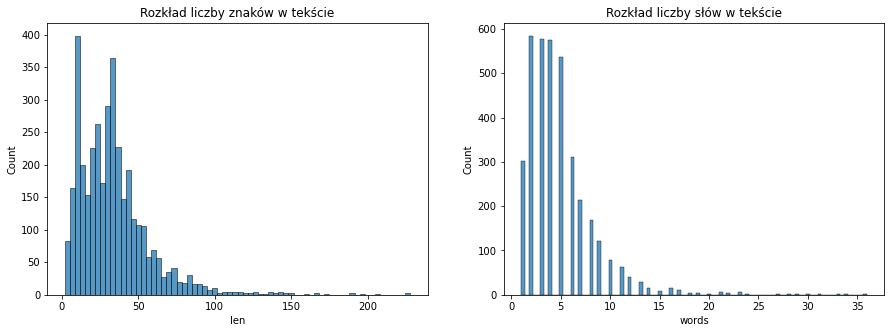

In [19]:
dist(ind)

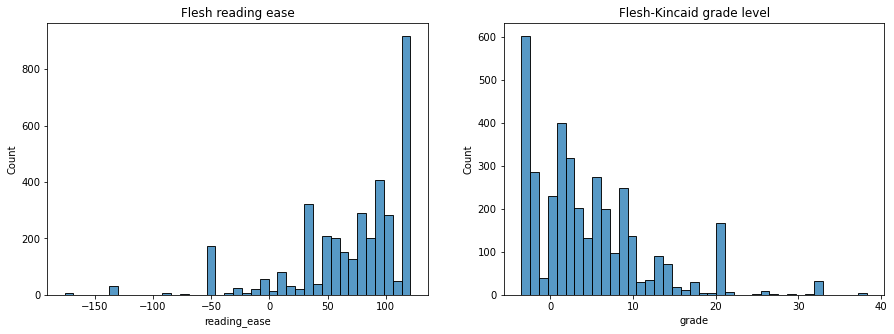

In [20]:
ease(ind)

In [21]:
ind['INDICATION'] = cleaning(ind['INDICATION'])

In [22]:
ind_en = vect(ind['INDICATION'])

ind_en

,aam,abd,abdomen,abdominal,ablation,abnormal,abnormality,about,abscess,abscesses,...,xiphoid,xol,xray,year,years,yellowish,yesterday,yof,yr,yrs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
stopwords, ind_en = stopw(ind_en)

['about', 'after', 'all', 'along', 'also', 'always', 'an', 'and', 'anything', 'are', 'around', 'at', 'back', 'be', 'been', 'before', 'behind', 'below', 'both', 'but', 'by', 'ca', 'could', 'does', 'due', 'eight', 'few', 'five', 'for', 'from', 'further', 'get', 'has', 'have', 'he', 'in', 'into', 'is', 'it', 'last', 'many', 'may', 'more', 'mostly', 'no', 'not', 'now', 'of', 'on', 'once', 'one', 'onto', 'or', 'other', 'otherwise', 'out', 'over', 'per', 'please', 're', 'several', 'she', 'side', 'since', 'six', 'some', 'than', 'that', 'the', 'this', 'three', 'throughout', 'to', 'two', 'under', 'up', 'us', 'using', 'very', 'was', 'well', 'who', 'will', 'with', 'without']
85


In [26]:
ind_en = lem(ind_en)

{'abscesses': 'abscess', 'aches': 'ache', 'acquired': 'acquire', 'actinomyces': 'actinomyce', 'admitted': 'admit', 'alleged': 'allege', 'altered': 'alter', 'ambulating': 'ambulate', 'antibiotics': 'antibiotic', 'assisted': 'assist', 'attacks': 'attack', 'attempting': 'attempt', 'bases': 'basis', 'beginning': 'begin', 'bleeding': 'bleed', 'bodyaches': 'bodyache', 'breasts': 'breast', 'breathing': 'breathe', 'bruising': 'bruise', 'bulging': 'bulge', 'caught': 'catch', 'causes': 'cause', 'changes': 'change', 'chills': 'chill', 'choking': 'choke', 'clubbing': 'club', 'codes': 'code', 'coming': 'come', 'comments': 'comment', 'complaining': 'complain', 'complains': 'complain', 'complaints': 'complaint', 'completed': 'complete', 'concerned': 'concern', 'conditions': 'condition', 'confused': 'confuse', 'continued': 'continue', 'crackles': 'crackle', 'cramping': 'cramp', 'crutches': 'crutch', 'dated': 'date', 'days': 'day', 'decreased': 'decrease', 'decreasing': 'decrease', 'dehydrated': 'dehyd

/tmp/ipykernel_32442/1598066314.py:23: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  data = data.sum(axis=1, level=0)


Number of rows after lemmatization:3691, number of columns: 1064.


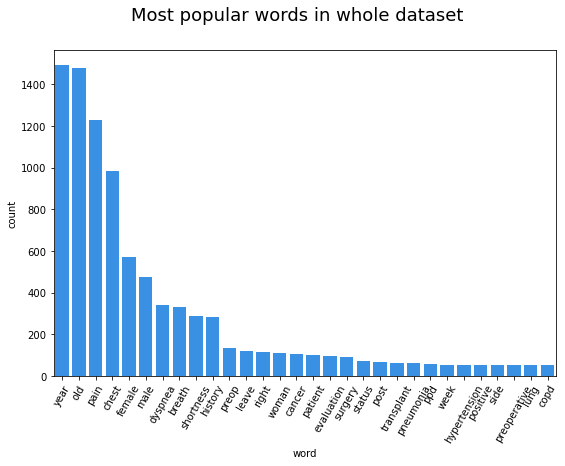

In [27]:
pop_words(ind_en)

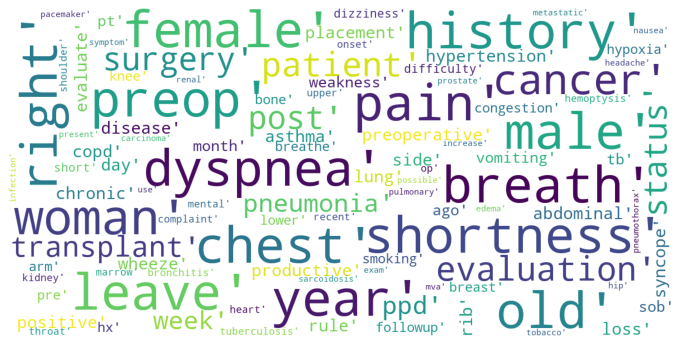

In [28]:
show_wordcloud(ind_en.sum().sort_values(ascending=False).to_dict())

## FINDINGS

In [29]:
fin = df[
    (df['FINDINGS'] != '') &
    (df['FINDINGS'] != 'XXXX') &
    (df['FINDINGS'] != 'XXXX.')
        ][['FINDINGS']]

fin

,FINDINGS
0,"Dual-XXXX cardiac pacemaker is in stable, XXXX..."
2,Right lower lobe patchy opacities noted. Heart...
3,Heart size and mediastinal contour are normal....
4,The cardiomediastinal silhouette and pulmonary...
6,"There is diffuse right-sided airspace disease,..."
...,...
3948,There is a large hiatal hernia. The stomach is...
3950,The cardiomediastinal silhouette is normal in ...
3951,There are XXXX left upper lobe opacities. Lung...
3952,Heart size is within normal limits. Aorta appe...


In [32]:
fin = stats(fin, 'FINDINGS')

fin

,FINDINGS,len,words,avg_sen,reading_ease,grade,sentences
0,"Dual-XXXX cardiac pacemaker is in stable, XXXX...",372,56,5.660714,47.45,8.4,8
2,Right lower lobe patchy opacities noted. Heart...,173,25,5.960000,49.48,7.6,5
3,Heart size and mediastinal contour are normal....,198,27,6.370370,32.15,10.1,5
4,The cardiomediastinal silhouette and pulmonary...,251,36,6.000000,53.88,8.0,4
6,"There is diffuse right-sided airspace disease,...",303,46,5.608696,51.34,9.0,4
...,...,...,...,...,...,...,...
3948,There is a large hiatal hernia. The stomach is...,376,62,5.080645,72.02,5.2,8
3950,The cardiomediastinal silhouette is normal in ...,344,43,7.023256,3.53,14.9,5
3951,There are XXXX left upper lobe opacities. Lung...,150,24,5.291667,65.39,5.6,4
3952,Heart size is within normal limits. Aorta appe...,269,38,6.105263,38.38,9.8,5


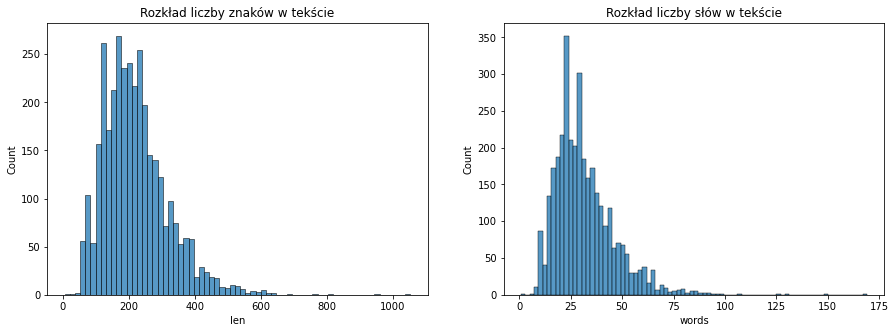

In [33]:
dist(fin)

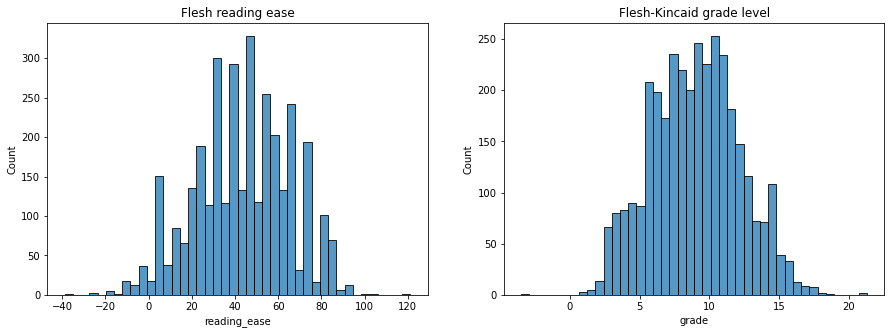

In [34]:
ease(fin)

In [35]:
fin['FINDINGS'] = cleaning(fin['FINDINGS'])

In [37]:
fin_en = vect(fin['FINDINGS'])

fin_en

,abdomen,abdominal,abnormal,abnormalities,abnormality,abnormally,about,above,absence,abut,...,worse,worsened,worsening,worst,would,wound,years,your,zone,zones
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
stopwords, fin_en = stopw(fin_en)

['about', 'above', 'after', 'again', 'all', 'along', 'already', 'also', 'although', 'amount', 'an', 'and', 'another', 'any', 'are', 'around', 'as', 'at', 'back', 'be', 'become', 'been', 'behind', 'below', 'besides', 'between', 'beyond', 'both', 'but', 'by', 'cannot', 'could', 'do', 'does', 'due', 'either', 'except', 'few', 'first', 'for', 'from', 'full', 'further', 'has', 'have', 'he', 'however', 'if', 'in', 'into', 'is', 'it', 'its', 'last', 'less', 'may', 'more', 'most', 'mostly', 'my', 'no', 'not', 'now', 'of', 'on', 'once', 'one', 'only', 'or', 'other', 'otherwise', 'over', 'part', 'perhaps', 'please', 're', 'same', 'see', 'seems', 'several', 'she', 'should', 'show', 'side', 'since', 'six', 'some', 'than', 'that', 'the', 'there', 'these', 'they', 'third', 'this', 'though', 'three', 'through', 'throughout', 'to', 'top', 'towards', 'two', 'under', 'up', 'upon', 'very', 'was', 'we', 'well', 'were', 'whether', 'which', 'whose', 'with', 'within', 'without', 'would', 'your']
119


In [57]:
fin_en = lem(fin_en)

{'broken': 'break', 'feeling': 'feel', 'scarring': 'scar', 'swallowing': 'swallow', 'vns': 'vn', 'walking': 'walk'}
Number of unique columns: 1460.
Number of columns: 1460.


/tmp/ipykernel_32442/1598066314.py:23: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  data = data.sum(axis=1, level=0)


Number of rows after lemmatization:3425, number of columns: 1460.


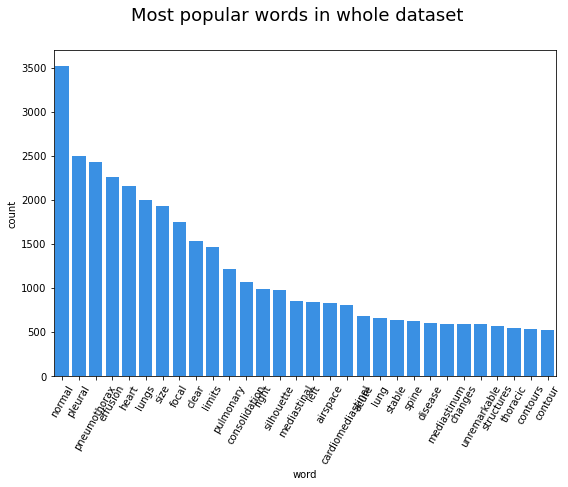

In [58]:
pop_words(fin_en)

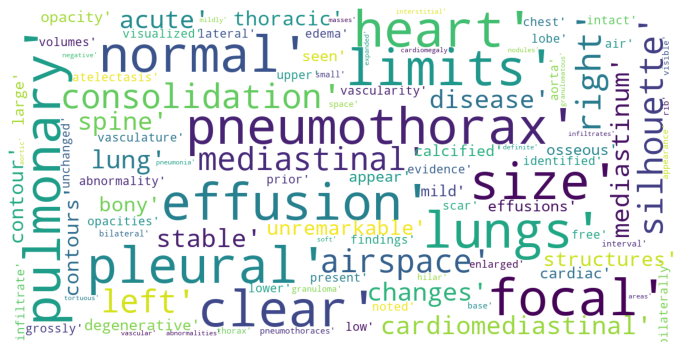

In [59]:
show_wordcloud(fin_en.sum().sort_values(ascending=False).to_dict())

## IMPRESSION

In [42]:
imp = df[
    (df['IMPRESSION'] != '') &
    (df['IMPRESSION'] != 'XXXX') &
    (df['IMPRESSION'] != 'XXXX.')
        ][['IMPRESSION']]

imp

,IMPRESSION
0,"Dual-XXXX cardiac pacemaker in stable, XXXX po..."
1,Moderate enlargement of the heart XXXX. This s...
2,"Patchy right lower lobe opacities, XXXX infect..."
3,Findings suggestive of emphysema. No acute car...
4,1. Clear lungs. 2. Mildly blunted right costop...
...,...
3950,Negative for acute abnormality.
3951,1. No evidence of active tuberculosis. 2. XXXX...
3952,1. Stable left chest dual XXXX ICD/pacemaker. ...
3953,No comparison chest x-XXXX. Minimal lingular s...


In [44]:
imp = stats(imp, 'IMPRESSION')

imp

,IMPRESSION,len,words,avg_sen,reading_ease,grade,sentences
0,"Dual-XXXX cardiac pacemaker in stable, XXXX po...",88,12,6.416667,31.55,10.4,2
1,Moderate enlargement of the heart XXXX. This s...,335,45,6.466667,28.50,11.5,5
2,"Patchy right lower lobe opacities, XXXX infect...",62,8,6.875000,37.98,10.0,1
3,Findings suggestive of emphysema. No acute car...,67,8,7.500000,33.58,9.6,2
4,1. Clear lungs. 2. Mildly blunted right costop...,92,13,6.153846,64.88,5.8,2
...,...,...,...,...,...,...,...
3950,Negative for acute abnormality.,31,4,7.000000,-8.73,15.5,1
3951,1. No evidence of active tuberculosis. 2. XXXX...,131,19,5.947368,31.24,10.5,3
3952,1. Stable left chest dual XXXX ICD/pacemaker. ...,115,15,6.250000,30.02,10.9,2
3953,No comparison chest x-XXXX. Minimal lingular s...,185,22,7.454545,16.25,12.1,5


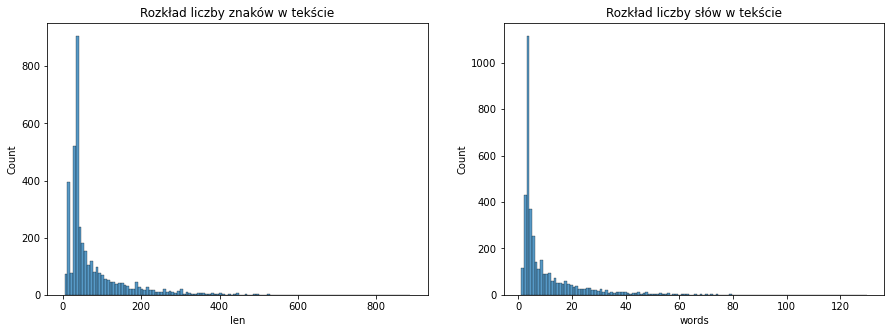

In [45]:
dist(imp)

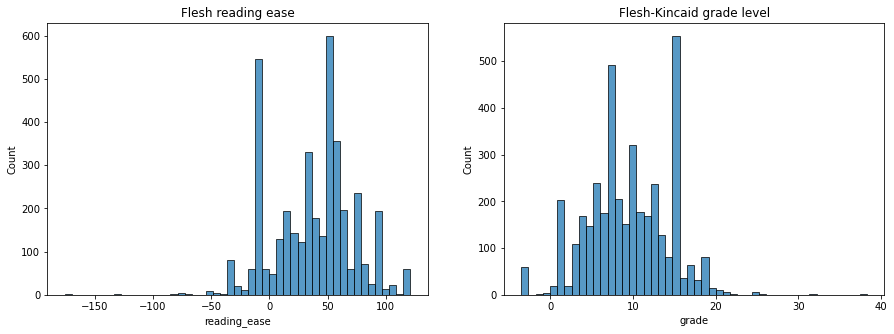

In [46]:
ease(imp)

In [47]:
imp['IMPRESSION'] = cleaning(imp['IMPRESSION'])

In [49]:
imp_en = vect(imp['IMPRESSION'])

imp_en

,abdomen,abdominal,aberrant,abnormal,abnormalities,abnormality,about,above,absence,accentuated,...,without,workup,worrisome,worse,worsening,would,wound,xray,your,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3918,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3919,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
stopwords, imp_en = stopw(imp_en)

['about', 'above', 'after', 'again', 'all', 'almost', 'along', 'already', 'also', 'although', 'amount', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'be', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'cannot', 'could', 'does', 'due', 'either', 'elsewhere', 'few', 'first', 'for', 'from', 'further', 'has', 'have', 'here', 'however', 'if', 'in', 'into', 'is', 'it', 'its', 'less', 'may', 'more', 'most', 'mostly', 'no', 'none', 'not', 'now', 'of', 'on', 'one', 'only', 'or', 'other', 'otherwise', 'out', 'over', 'part', 'per', 'perhaps', 'please', 'regarding', 'same', 'see', 'several', 'she', 'should', 'show', 'side', 'since', 'some', 'something', 'than', 'that', 'the', 'then', 'there', 'these', 'this', 'those', 'though', 'three', 'through', 'throughout', 'to', 'top', 'two', 'under', 'unless', 'until', 'up', 'very', 'was', 'well', 'were', 'whether', 'which', 'whose', 'will', 'with', 'within', 'without', 'would', 'your']
114


In [53]:
imp_en = lem(imp_en)

{'broken': 'break', 'feeling': 'feel', 'scarring': 'scar', 'swallowing': 'swallow', 'vns': 'vn', 'walking': 'walk'}
Number of unique columns: 1375.
Number of columns: 1376.


/tmp/ipykernel_32442/1598066314.py:23: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  data = data.sum(axis=1, level=0)


Number of rows after lemmatization:3921, number of columns: 1375.


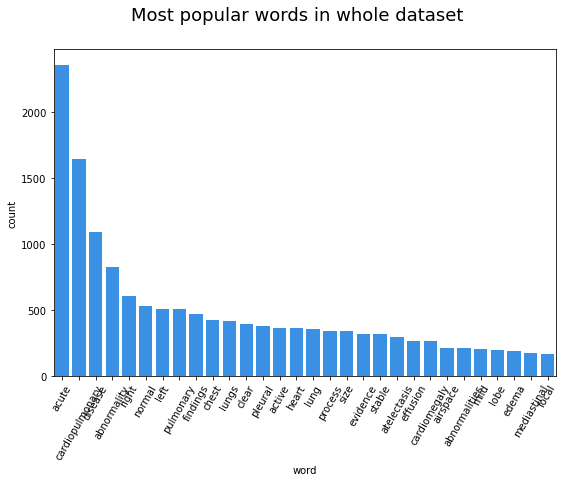

In [54]:
pop_words(imp_en)

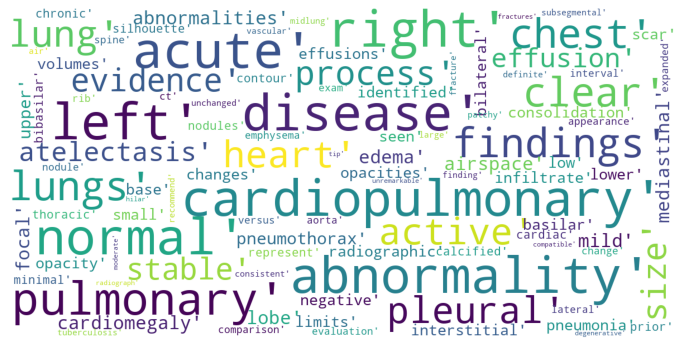

In [55]:
show_wordcloud(imp_en.sum().sort_values(ascending=False).to_dict())